In [36]:
import numpy as np
import pandas as pd
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/snehal/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/snehal/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
df = pd.read_csv("google-mini-(Crawl-Run)---2020-03-03T190010Z.csv")

In [38]:
df1 = pd.read_csv("google-mini-negative-(Crawl-Run)---2020-03-03T183536Z.csv")

In [39]:
df.shape

(2000, 11)

In [40]:
df1.shape

(1048, 11)

In [41]:
df.columns

Index(['url', 'User Name', 'Quality', 'Value', 'Ease of Use', 'Stars',
       'Unnamed: 6', 'Posted', 'Review', 'Helpful', 'Unhelpful'],
      dtype='object')

In [42]:
df1.columns

Index(['url', 'User Name', 'Quality', 'Value', 'Ease of Use', 'Stars',
       'Unnamed: 6', 'Posted', 'Review', 'Helpful', 'Unhelpful'],
      dtype='object')

In [43]:
df = pd.DataFrame(df,columns = ['Stars','Review'])

In [44]:
df1 = pd.DataFrame(df1,columns = ['Stars','Review'])

In [45]:
data = df.append(df1)

In [46]:
data.to_csv("Google_mini_combines.csv")

In [47]:
data.Stars.unique()

array([5, 4, 2, 3, 1])

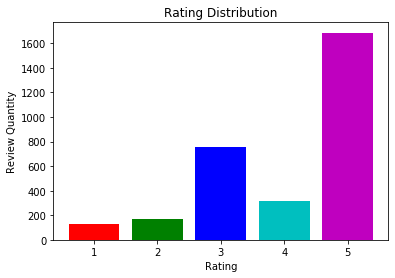

In [48]:
#seperating by groups
groups = data.groupby('Stars').count()
Values = groups.Review
colors = ['r', 'g', 'b', 'c', 'm']
#making bar plot
plt.bar(([1,2,3,4,5]), Values, color= colors)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Review Quantity')
plt.show()

In [49]:
data["bad_review"] = data["Stars"].apply(lambda x: 1 if x < 4 else 0)

In [50]:
!pip install vaderSentiment

In [51]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [52]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [53]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
# reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

In [54]:
data['review_clean'] = data["Review"].apply(lambda x: clean_text(x))

In [55]:
# add number of characters column
data["nb_chars"] = data["review_clean"].apply(lambda x: len(x))

# add number of words column
data["nb_words"] = data["review_clean"].apply(lambda x: len(x.split(" ")))

In [56]:
data["nb_chars"]


0       725
1       308
2       197
3       106
4        96
       ... 
1043    373
1044     84
1045    262
1046     20
1047     99
Name: nb_chars, Length: 3048, dtype: int64

In [57]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = data["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([data, doc2vec_df], axis=1)

In [58]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(data["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = data.index
reviews_df = pd.concat([data, tfidf_df], axis=1)

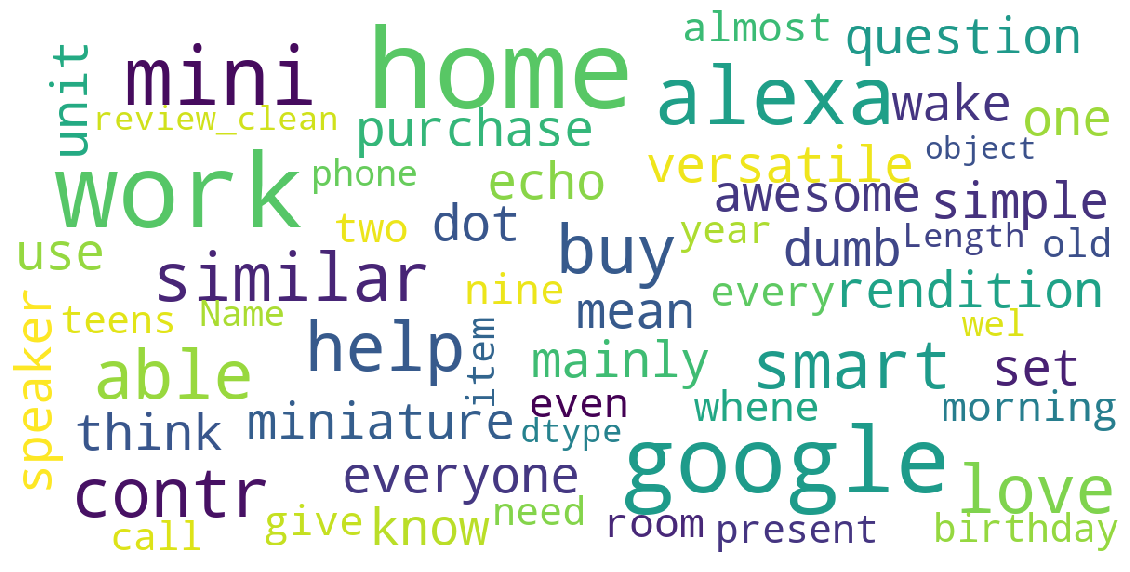

In [59]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data[data['bad_review']==0]['review_clean'])

In [60]:
data['word_count'] = data['review_clean'].apply(lambda x: len(str(x).split(" ")))
data[['review_clean','word_count']].head()

,review_clean,word_count
0,google home mini versatile miniature rendition...,107
1,purchase one mean everyone else get home think...,53
2,smart home unit awesome mainly use google home...,31
3,echo dot alexa dumb simple question know help ...,17
4,love smart speaker set wake work morning whene...,17


In [61]:
data['char_count'] = data['review_clean'].str.len() ## this also includes spaces
data[['review_clean','char_count']].head()

,review_clean,char_count
0,google home mini versatile miniature rendition...,725
1,purchase one mean everyone else get home think...,308
2,smart home unit awesome mainly use google home...,197
3,echo dot alexa dumb simple question know help ...,106
4,love smart speaker set wake work morning whene...,96


In [62]:
data.bins = pd.cut(data['char_count'], 10).head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [63]:
max(data['char_count'])

1726

In [64]:
data['bins'] = pd.cut(x=data['char_count'], bins=[1, 20, 40, 50,60,80,99,149,199,249,299,500,800,1000,1300,1315])
data['bins']
print(data['bins'].unique())

[(500, 800], (299, 500], (149, 199], (99, 149], (80, 99], ..., (1.0, 20.0], (1300.0, 1315.0], (1000.0, 1300.0], (800.0, 1000.0], NaN]
Length: 16
Categories (15, interval[int64]): [(1, 20] < (20, 40] < (40, 50] < (50, 60] ... (500, 800] < (800, 1000] < (1000, 1300] < (1300, 1315]]


<Figure size 1440x720 with 0 Axes>

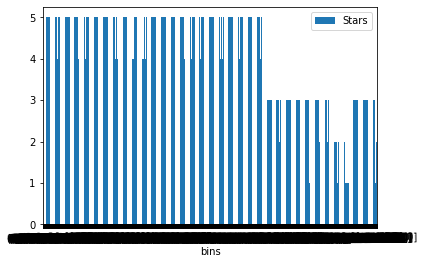

<Figure size 1440x720 with 0 Axes>

In [65]:
ax = data.plot.bar(x='bins', y='Stars', rot=1)
plt.figure(figsize=(20,10))

In [66]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data['avg_word'] = data['Review'].apply(lambda x: avg_word(x))
data[['Review','avg_word']].head()

,Review,avg_word
0,Google Home Mini is a versatile miniature rend...,4.666667
1,"Purchased one of these for myself because, I m...",3.942149
2,This smart home unit is awesome! I mainly use ...,4.388889
3,"I have the Echo Dot, and Alexa is too dumb for...",4.250000
4,I love this smart speaker. I set it up to wake...,3.486486


In [67]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['stopwords'] = data['review_clean'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['review_clean','stopwords']].head()

,review_clean,stopwords
0,google home mini versatile miniature rendition...,3
1,purchase one mean everyone else get home think...,0
2,smart home unit awesome mainly use google home...,0
3,echo dot alexa dumb simple question know help ...,0
4,love smart speaker set wake work morning whene...,0


In [68]:
data['hastags'] = data['review_clean'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
data[['review_clean','hastags']].head()

,review_clean,hastags
0,google home mini versatile miniature rendition...,0
1,purchase one mean everyone else get home think...,0
2,smart home unit awesome mainly use google home...,0
3,echo dot alexa dumb simple question know help ...,0
4,love smart speaker set wake work morning whene...,0


In [69]:
data['numerics'] = data['review_clean'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
data[['review_clean','numerics']].head()

,review_clean,numerics
0,google home mini versatile miniature rendition...,0
1,purchase one mean everyone else get home think...,0
2,smart home unit awesome mainly use google home...,0
3,echo dot alexa dumb simple question know help ...,0
4,love smart speaker set wake work morning whene...,0


In [70]:
data['upper'] = data['review_clean'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
data[['review_clean','upper']].head()

,review_clean,upper
0,google home mini versatile miniature rendition...,0
1,purchase one mean everyone else get home think...,0
2,smart home unit awesome mainly use google home...,0
3,echo dot alexa dumb simple question know help ...,0
4,love smart speaker set wake work morning whene...,0


In [71]:
data['Text_length']=data['review_clean'].apply(lambda col: len(col.split(' ')))


data

,Stars,Review,bad_review,review_clean,nb_chars,nb_words,word_count,char_count,bins,avg_word,stopwords,hastags,numerics,upper,Text_length
0,5,Google Home Mini is a versatile miniature rend...,0,google home mini versatile miniature rendition...,725,107,107,725,"(500, 800]",4.666667,3,0,0,0,107
1,5,"Purchased one of these for myself because, I m...",0,purchase one mean everyone else get home think...,308,53,53,308,"(299, 500]",3.942149,0,0,0,0,53
2,5,This smart home unit is awesome! I mainly use ...,0,smart home unit awesome mainly use google home...,197,31,31,197,"(149, 199]",4.388889,0,0,0,0,31
3,5,"I have the Echo Dot, and Alexa is too dumb for...",0,echo dot alexa dumb simple question know help ...,106,17,17,106,"(99, 149]",4.250000,0,0,0,0,17
4,5,I love this smart speaker. I set it up to wake...,0,love smart speaker set wake work morning whene...,96,17,17,96,"(80, 99]",3.486486,0,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,2,switched from an Echo to this since our entire...,1,switch echo since entire house google base ass...,373,56,56,373,"(299, 500]",4.644231,0,0,0,0,56
1044,1,The 29.99 google assistant has very limited ca...,1,google assistant limit capacity answer questio...,84,11,11,84,"(80, 99]",4.833333,0,0,0,0,11
1045,1,This device sucks in comparison to the echo. T...,1,device suck comparison echo way control access...,262,42,42,262,"(249, 299]",4.056180,0,0,0,0,42
1046,1,Cool and. Fun I love it ......... ...............,1,cool fun love thanks,20,4,4,20,"(1, 20]",5.666667,0,0,0,0,4


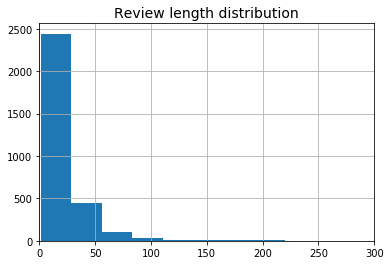

In [72]:
data['Text_length'].hist();
plt.xlim(0,300)
plt.title('Review length distribution',fontsize=14);

In [73]:
data['Text_length'].describe()

count    3048.000000
mean       20.463255
std        21.178178
min         1.000000
25%         8.000000
50%        13.000000
75%        24.000000
max       275.000000
Name: Text_length, dtype: float64

In [74]:
#tokenization
tokenized_review = data['review_clean'].apply(lambda x: x.split())
tokenized_review.head()

0    [google, home, mini, versatile, miniature, ren...
1    [purchase, one, mean, everyone, else, get, hom...
2    [smart, home, unit, awesome, mainly, use, goog...
3    [echo, dot, alexa, dumb, simple, question, kno...
4    [love, smart, speaker, set, wake, work, mornin...
Name: review_clean, dtype: object

In [75]:
#stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_review = tokenized_review.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_review.head()

0    [googl, home, mini, versatil, miniatur, rendit...
1    [purchas, one, mean, everyon, els, get, home, ...
2    [smart, home, unit, awesom, mainli, use, googl...
3    [echo, dot, alexa, dumb, simpl, question, know...
4    [love, smart, speaker, set, wake, work, morn, ...
Name: review_clean, dtype: object

In [76]:
# for i in range(len(tokenized_review)):
#     tokenized_review[i] = ' '.join(tokenized_review[i])

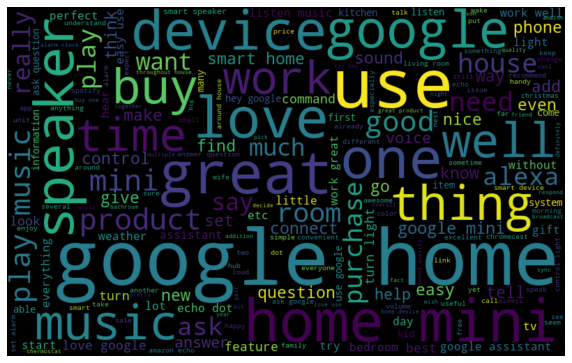

In [77]:
all_words = ' '.join([text for text in data[data['bad_review']==0]['review_clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

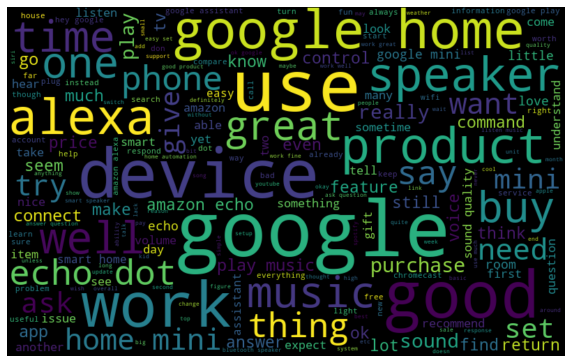

In [78]:
all_words = ' '.join([text for text in data[data['bad_review']==1]['review_clean']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [79]:
print("Percentage null or na values in df")
((data.isnull() | data.isna()).sum() * 100 / data.index.size).round(2)

Percentage null or na values in df


Stars           0.0
Review          0.0
bad_review      0.0
review_clean    0.0
nb_chars        0.0
nb_words        0.0
word_count      0.0
char_count      0.0
bins            0.1
avg_word        0.0
stopwords       0.0
hastags         0.0
numerics        0.0
upper           0.0
Text_length     0.0
dtype: float64

In [80]:
# show is_bad_review distribution
data["bad_review"].value_counts(normalize = True)

0    0.656168
1    0.343832
Name: bad_review, dtype: float64

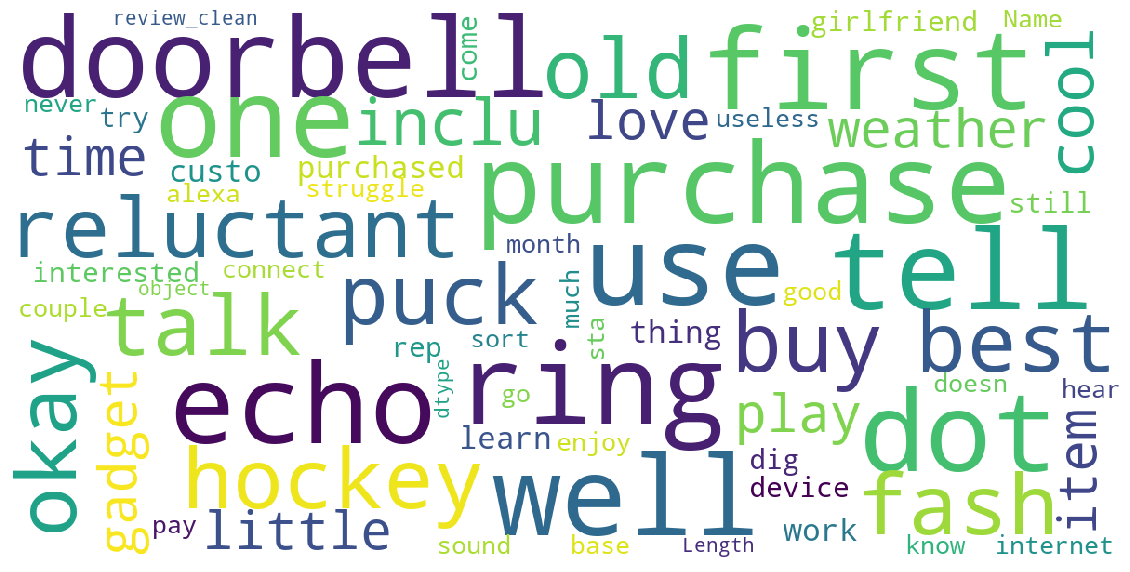

In [41]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(data["review_clean"])

In [42]:
# highest positive sentiment reviews (with more than 5 words)
data[data["nb_words"] >= 5].sort_values("pos", ascending = False)[["review_clean", "pos"]].head(10)

KeyError: 'pos'

In [41]:
data['Tidy_Review'] = data['review_clean'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [42]:
tokenized_tweet = data['Tidy_Review'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [google, home, mini, versatile, miniature, ren...
1    [purchase, mean, everyone, else, home, think, ...
2    [smart, home, unit, awesome, mainly, google, h...
3    [echo, alexa, dumb, simple, question, know, he...
4    [love, smart, speaker, wake, work, morning, wh...
Name: Tidy_Review, dtype: object

In [43]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [googl, home, mini, versatil, miniatur, rendit...
1    [purchas, mean, everyon, els, home, think, ugh...
2    [smart, home, unit, awesom, mainli, googl, hom...
3    [echo, alexa, dumb, simpl, question, know, hel...
4    [love, smart, speaker, wake, work, morn, whene...
Name: Tidy_Review, dtype: object

In [44]:
values = ','.join(str(v) for v in tokenized_tweet)

data['Tidy_Review'] = values

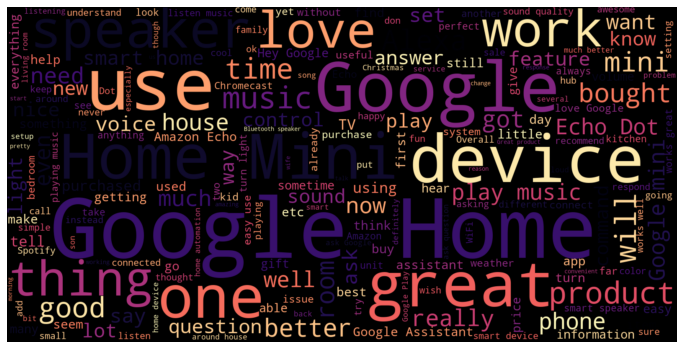

In [45]:
all_tweets = data
all_string = []
for t in all_tweets.Review:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

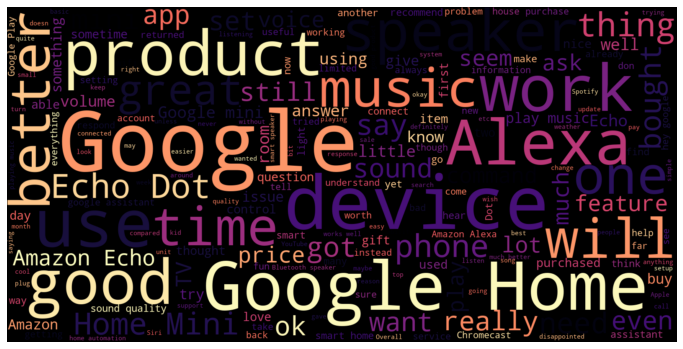

In [46]:
neg_tweets = data[data.bad_review == 1]
neg_string = []
for t in neg_tweets.Review:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(neg_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

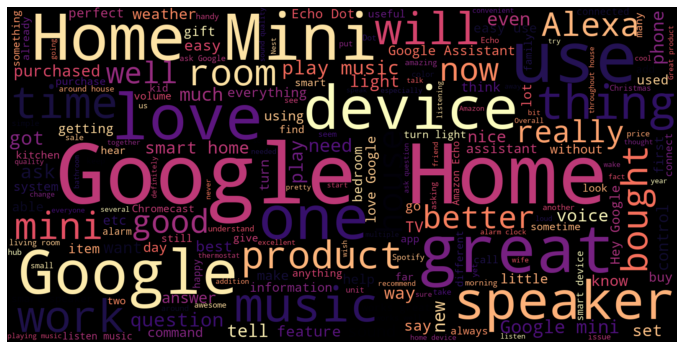

In [47]:
pos_review = data[data.bad_review == 0]
pos_string = []
for t in pos_review.Review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [66]:
x = []
for t in data.Review[:]:
    if 'Alexa' in t:
        x.append(t)
        

In [67]:
x

["I have the Echo Dot, and Alexa is too dumb for me. Simple questions she doesn't know how to help. Google Home Mini impressed me so far. The speaker is more deep and louder the competition.",
 'I’ve had an Alexa Echo for about a year now and the Home Mini is smarter, allowing multiple commands and more precise control. The only downside is you can’t connect a Bluetooth speaker. The only way to connect an external speaker is if it has a Chromecast.',
 'It is right on par with Alexa. I enjoy using it. I google Home',
 'The google home mini is, in my experience, a very handy little device. I originally came to Best Buy only to get a chromecast because I needed a way to stream Netflix and Hulu to my old (and cheap) tv, but I snagged the mini as well when I saw it was on sale for just 30 dollars. I had some Best Buy rewards too so really, it was just an impulse buy. I wanted one and now could afford it, so why not? Novelty as I thought it would be, it has proven me so wrong. I use it to pa

In [81]:
alexa = ["alexa","Alexa","echo","Echo","dot","Dot"]
data['has_alexa'] = data['review_clean'].apply(lambda x: len([x for x in x.split() if x in alexa]))
data[['review_clean','has_alexa']].head()

,review_clean,has_alexa
0,google home mini versatile miniature rendition...,0
1,purchase one mean everyone else get home think...,0
2,smart home unit awesome mainly use google home...,0
3,echo dot alexa dumb simple question know help ...,3
4,love smart speaker set wake work morning whene...,0


In [82]:
len(data[(data.has_alexa==1)& (data.bad_review ==1)])


140

In [77]:
words = [w.replace('Alexa', '') for w in x]


In [78]:
words = [w.replace('Google', '') for w in words]


In [83]:
words = [w.replace('Amazon', '') for w in words]
words = [w.replace('mini', '') for w in words]
words = [w.replace('Mini', '') for w in words]
words = [w.replace('home', '') for w in words]
words = [w.replace('google', '') for w in words]

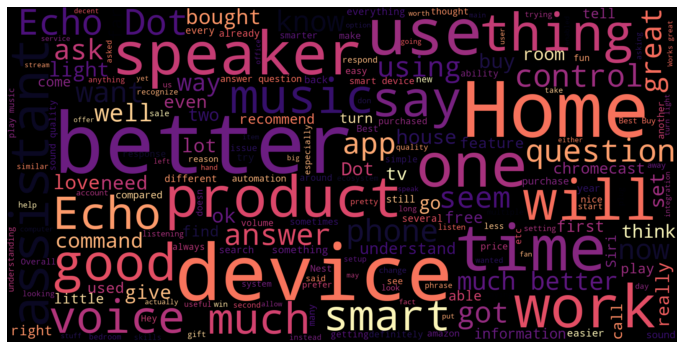

In [84]:
pos_review = words
pos_string = []
for t in pos_review:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [85]:
import seaborn as sns

for x in [0, 1]:
    subset = data[data['bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

KeyError: 'compound'

In [57]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(data.review_clean)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [58]:
len(cvec.get_feature_names())

3113

In [59]:
neg_doc_matrix = cvec.transform(data[data.bad_review == 0].review_clean)
pos_doc_matrix = cvec.transform(data[data.bad_review == 1].review_clean)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [60]:
term_freq_df

,0,1
abbott,1,0
ability,16,2
able,51,27
absolute,1,0
absolutely,29,2
...,...,...
yr,2,0
zero,1,0
zip,0,1
zlexa,1,0


In [61]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
use,614,221,835
echo,593,164,757
love,702,21,723
great,577,94,671
dot,495,143,638
music,498,110,608
one,470,103,573
alexa,389,156,545
get,379,155,534
work,310,162,472


Text(0.5, 1.0, 'Top 500 tokens in tweets')

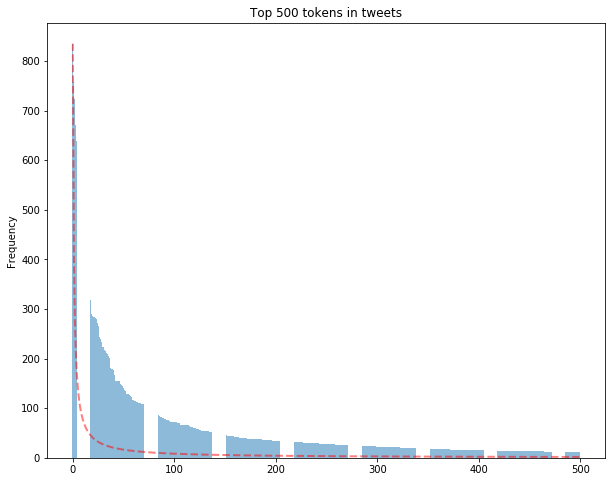

In [62]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')

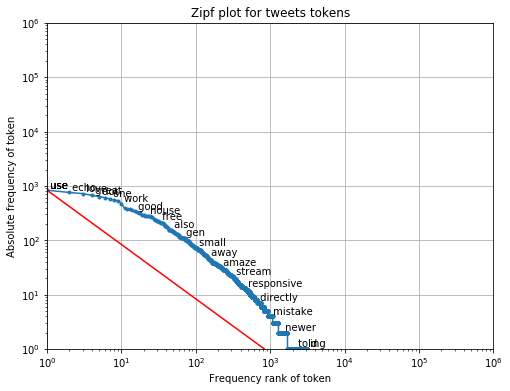

In [63]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

Text(0.5, 1.0, 'Top 50 tokens in negative tweets')

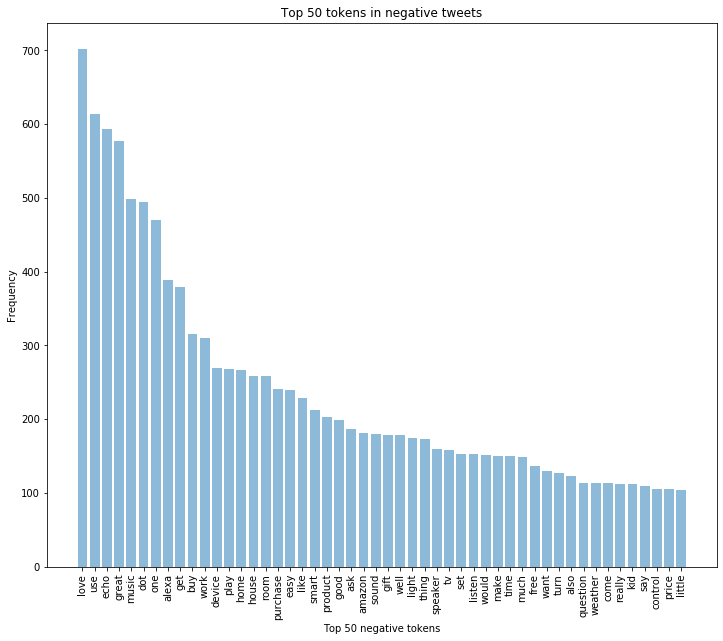

In [65]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

Text(0.5, 1.0, 'Top 50 tokens in positive tweets')

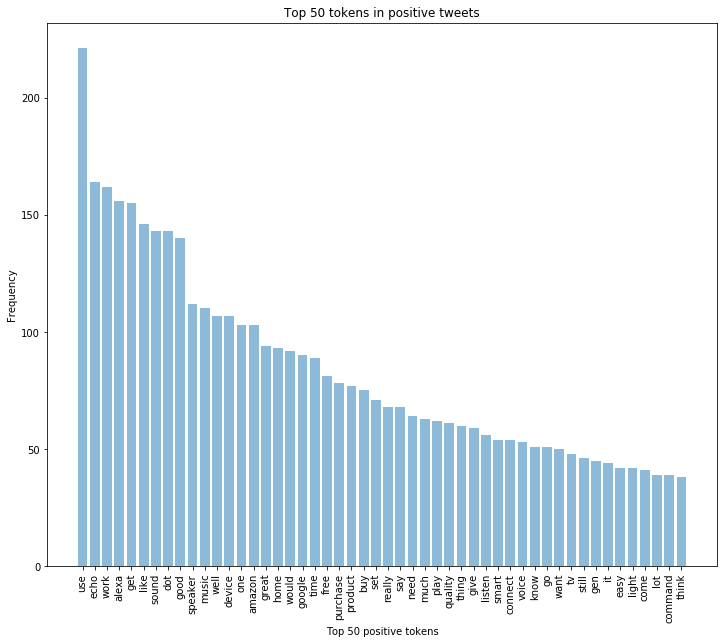

In [76]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

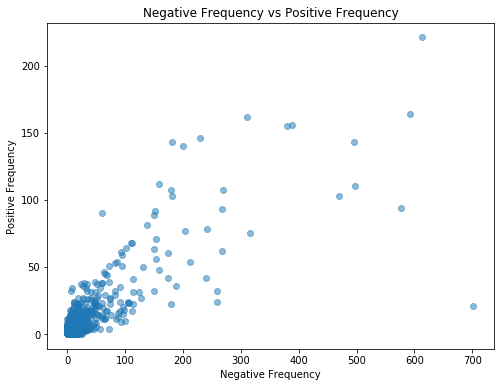

In [77]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [79]:
term_freq_df['pos_rate'] = term_freq_df['positive'] * 1./term_freq_df['total']
term_freq_df.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
reading,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
umm,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
consumption,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
jack,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
itunes,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
understood,0,2,2,1.0,0.000178,0.000356,0.952712,0.448784,0.610150,0.0,0.0,0.0,0.047288,0.406989,0.084731
iteration,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
isnt,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
understad,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731
is,0,1,1,1.0,0.000089,0.000178,0.952712,0.417350,0.580432,0.0,0.0,0.0,0.047288,0.406989,0.084731


In [80]:
term_freq_df['pos_freq_pct'] = term_freq_df['positive'] * 1./term_freq_df['positive'].sum()
term_freq_df.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
use,614,221,835,0.264671,0.019664,0.036608,0.408391,1.0,0.579940,0.735329,0.022737,0.044109,0.591609,1.000000,0.743410
echo,593,164,757,0.216645,0.014592,0.027342,0.360919,1.0,0.530405,0.783355,0.021959,0.042720,0.639081,1.000000,0.779804
work,310,162,472,0.343220,0.014414,0.027666,0.488689,1.0,0.656536,0.656780,0.011479,0.022564,0.511311,1.000000,0.676646
alexa,389,156,545,0.286239,0.013880,0.026477,0.430203,1.0,0.601597,0.713761,0.014405,0.028240,0.569797,1.000000,0.725950
get,379,155,534,0.290262,0.013791,0.026331,0.434298,1.0,0.605590,0.709738,0.014034,0.027525,0.565702,1.000000,0.722617
like,229,146,375,0.389333,0.012990,0.025142,0.536257,1.0,0.698134,0.610667,0.008480,0.016728,0.463743,1.000000,0.633640
sound,180,143,323,0.442724,0.012724,0.024736,0.590648,1.0,0.742651,0.557276,0.006665,0.013173,0.409352,0.999998,0.580908
dot,495,143,638,0.224138,0.012724,0.024080,0.368207,1.0,0.538233,0.775862,0.018330,0.035814,0.631793,1.000000,0.774354
good,199,140,339,0.412979,0.012457,0.024184,0.560492,1.0,0.718353,0.587021,0.007369,0.014555,0.439508,1.000000,0.610636
speaker,159,112,271,0.413284,0.009965,0.019461,0.560803,1.0,0.718608,0.586716,0.005888,0.011659,0.439197,0.999977,0.610332


In [81]:
from scipy.stats import hmean
term_freq_df['pos_hmean'] = term_freq_df.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])                                                               if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 else 0), axis=1)
                                                       
term_freq_df.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
use,614,221,835,0.264671,0.019664,0.036608,0.408391,1.0,0.579940,0.735329,0.022737,0.044109,0.591609,1.000000,0.743410
work,310,162,472,0.343220,0.014414,0.027666,0.488689,1.0,0.656536,0.656780,0.011479,0.022564,0.511311,1.000000,0.676646
echo,593,164,757,0.216645,0.014592,0.027342,0.360919,1.0,0.530405,0.783355,0.021959,0.042720,0.639081,1.000000,0.779804
alexa,389,156,545,0.286239,0.013880,0.026477,0.430203,1.0,0.601597,0.713761,0.014405,0.028240,0.569797,1.000000,0.725950
get,379,155,534,0.290262,0.013791,0.026331,0.434298,1.0,0.605590,0.709738,0.014034,0.027525,0.565702,1.000000,0.722617
like,229,146,375,0.389333,0.012990,0.025142,0.536257,1.0,0.698134,0.610667,0.008480,0.016728,0.463743,1.000000,0.633640
sound,180,143,323,0.442724,0.012724,0.024736,0.590648,1.0,0.742651,0.557276,0.006665,0.013173,0.409352,0.999998,0.580908
good,199,140,339,0.412979,0.012457,0.024184,0.560492,1.0,0.718353,0.587021,0.007369,0.014555,0.439508,1.000000,0.610636
dot,495,143,638,0.224138,0.012724,0.024080,0.368207,1.0,0.538233,0.775862,0.018330,0.035814,0.631793,1.000000,0.774354
speaker,159,112,271,0.413284,0.009965,0.019461,0.560803,1.0,0.718608,0.586716,0.005888,0.011659,0.439197,0.999977,0.610332


In [82]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df['pos_rate_normcdf'] = normcdf(term_freq_df['pos_rate'])
term_freq_df['pos_freq_pct_normcdf'] = normcdf(term_freq_df['pos_freq_pct'])
term_freq_df['pos_normcdf_hmean'] = hmean([term_freq_df['pos_rate_normcdf'], term_freq_df['pos_freq_pct_normcdf']])
term_freq_df.sort_values(by='pos_normcdf_hmean',ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
ok,6,32,38,0.842105,0.002847,0.005675,0.896710,0.988382,0.940317,0.157895,0.000222,0.000444,0.103290,0.471081,0.169431
return,8,34,42,0.809524,0.003025,0.006028,0.880738,0.992439,0.933258,0.190476,0.000296,0.000592,0.119262,0.492697,0.192039
wifi,11,24,35,0.685714,0.002135,0.004258,0.804609,0.948450,0.870628,0.314286,0.000407,0.000814,0.195391,0.525143,0.284811
reason,5,18,23,0.782609,0.001602,0.003197,0.866288,0.875000,0.870622,0.217391,0.000185,0.000370,0.133712,0.460300,0.207227
doesn,12,24,36,0.666667,0.002135,0.004257,0.790712,0.948450,0.862428,0.333333,0.000444,0.000888,0.209288,0.535932,0.301022
understand,23,37,60,0.616667,0.003292,0.006549,0.751579,0.996199,0.856771,0.383333,0.000852,0.001700,0.248421,0.651196,0.359643
respond,11,22,33,0.666667,0.001957,0.003903,0.790712,0.929235,0.854396,0.333333,0.000407,0.000814,0.209288,0.525143,0.299296
google,59,90,149,0.604027,0.008008,0.015806,0.741103,1.000000,0.851303,0.395973,0.002185,0.004346,0.258897,0.913875,0.403488
month,6,17,23,0.739130,0.001513,0.003019,0.840489,0.857782,0.849047,0.260870,0.000222,0.000444,0.159511,0.471081,0.238324
week,7,17,24,0.708333,0.001513,0.003019,0.820363,0.857782,0.838655,0.291667,0.000259,0.000518,0.179637,0.481882,0.261712


In [83]:
term_freq_df['neg_rate'] = term_freq_df['negative'] * 1./term_freq_df['total']
term_freq_df['neg_freq_pct'] = term_freq_df['negative'] * 1./term_freq_df['negative'].sum()
term_freq_df['neg_hmean'] = term_freq_df.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])                                                                if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0                                                                else 0), axis=1)
                                                       
term_freq_df['neg_rate_normcdf'] = normcdf(term_freq_df['neg_rate'])
term_freq_df['neg_freq_pct_normcdf'] = normcdf(term_freq_df['neg_freq_pct'])
term_freq_df['neg_normcdf_hmean'] = hmean([term_freq_df['neg_rate_normcdf'], term_freq_df['neg_freq_pct_normcdf']])
term_freq_df.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
love,702,21,723,0.029046,0.001868,0.003511,0.200003,0.917762,0.328433,0.970954,0.025995,0.050635,0.799997,1.000000,0.888887
house,259,24,283,0.084806,0.002135,0.004166,0.242816,0.948450,0.386645,0.915194,0.009591,0.018983,0.757184,1.000000,0.861815
daughter,71,4,75,0.053333,0.000356,0.000707,0.218066,0.512425,0.305938,0.946667,0.002629,0.005244,0.781934,0.954534,0.859656
family,93,9,102,0.088235,0.000801,0.001587,0.245602,0.666716,0.358969,0.911765,0.003444,0.006862,0.754398,0.988909,0.855880
christmas,99,10,109,0.091743,0.000890,0.001762,0.248469,0.695257,0.366102,0.908257,0.003666,0.007303,0.751531,0.992857,0.855501
gift,179,22,201,0.109453,0.001957,0.003846,0.263212,0.929235,0.410226,0.890547,0.006628,0.013159,0.736788,0.999998,0.848448
room,258,32,290,0.110345,0.002847,0.005551,0.263967,0.988382,0.416657,0.889655,0.009554,0.018905,0.736033,1.000000,0.847948
fun,84,11,95,0.115789,0.000979,0.001941,0.268594,0.722656,0.391629,0.884211,0.003111,0.006199,0.731406,0.979479,0.837458
kid,112,17,129,0.131783,0.001513,0.002991,0.282419,0.857782,0.424932,0.868217,0.004147,0.008255,0.717581,0.997465,0.834686
son,57,4,61,0.065574,0.000356,0.000708,0.227515,0.512425,0.315119,0.934426,0.002111,0.004212,0.772485,0.905031,0.833522


Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

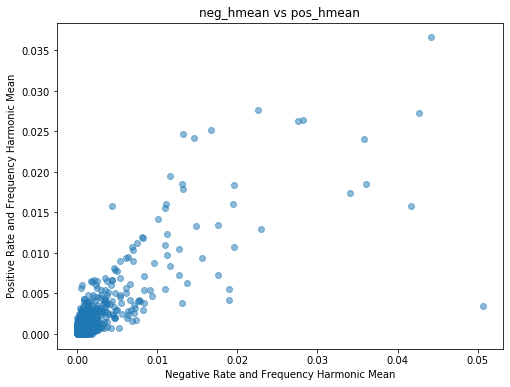

In [84]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

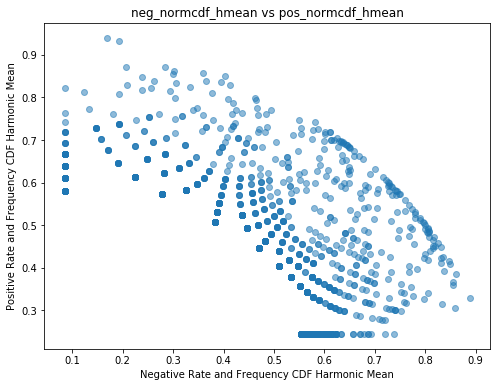

In [85]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [196]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
from bokeh.models import HoverTool
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df.pos_normcdf_hmean), high=max(term_freq_df.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [86]:
X = data.review_clean
y = data.bad_review

SEED = 2000
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=SEED)

print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
(len(X_train[y_train == 1]) / (len(X_train)*1.))*100,
(len(X_train[y_train == 0]) / (len(X_train)*1.))*100))

print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
(len(X_test[y_test == 1]) / (len(X_test)*1.))*100,
(len(X_test[y_test == 0]) / (len(X_test)*1.))*100))


Train set has total 2438 entries with 33.84% negative, 66.16% positive
Test set has total 610 entries with 36.56% negative, 63.44% positive


In [87]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
tbresult = [TextBlob(i).sentiment.polarity for i in X_test]
tbpred = [0 if n < 0 else 1 for n in tbresult]
conmat = np.array(confusion_matrix(y_test, tbpred, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
print("Accuracy Score: {0:.2f}%".format(accuracy_score(y_test, tbpred)*100))
print("-"*80)
print("Confusion Matrix\n")
print(confusion)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_test, tbpred))

Accuracy Score: 34.26%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                 193                  30
positive                 371                  16
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.35      0.04      0.07       387
           1       0.34      0.87      0.49       223

    accuracy                           0.34       610
   macro avg       0.35      0.45      0.28       610
weighted avg       0.35      0.34      0.23       610



In [108]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(X)
dummy_clf.score(X, y)

0.7353698932646301

In [109]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [110]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)
def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print(classifier)
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

In [111]:
from sklearn.feature_extraction import text
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

False

In [112]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))

In [113]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Validation result for 10000 features
null accuracy: 72.79%
accuracy score: 81.62%
model is 8.82% more accurate than null accuracy
train and test time: 0.15s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 72.79%
accuracy score: 81.62%
model is 8.82% more accurate than null accuracy
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 72.79%
accuracy score: 81.62%
model is 8.82% more accurate than null accuracy
train and test time: 0.11s
--

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.15s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.14s
--------------------------------------------------------------------------------
Validation result for 30000 features


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.13s
--------------------------------------------------------------------------------
Validation result for 40000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.13s
--------------------------------------------------------------------------------
Validation result for 50000 features


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.13s
--------------------------------------------------------------------------------
Validation result for 60000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.12s
--------------------------------------------------------------------------------
Validation result for 70000 features


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.14s
--------------------------------------------------------------------------------
Validation result for 80000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.14s
--------------------------------------------------------------------------------
Validation result for 90000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.16s
--------------------------------------------------------------------------------
Validation result for 100000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.14s
--------------------------------------------------------------------------------


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

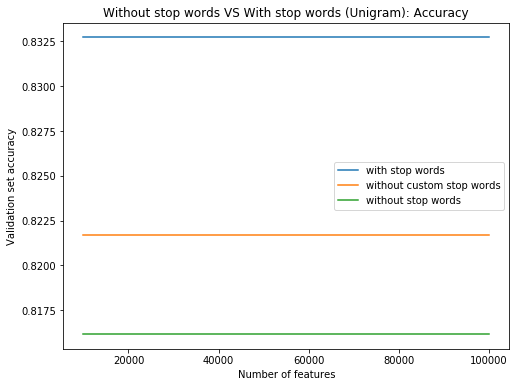

In [115]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [116]:
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1, 2))
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Validation result for 10000 features
null accuracy: 72.79%
accuracy score: 85.11%
model is 12.32% more accurate than null accuracy
train and test time: 0.35s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 72.79%
accuracy score: 85.11%
model is 12.32% more accurate than null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 72.79%
accuracy score: 85.29%
model is 12.50% more accurate than null accuracy
train and test time: 0.40s
---

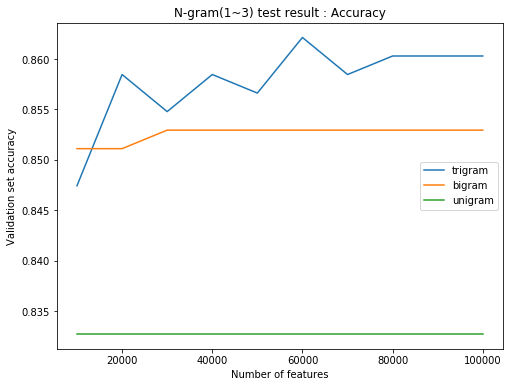

In [118]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [119]:
def train_test_and_evaluate(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['positive','negative']))

In [120]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, X_train, y_train, X_test, y_test)

null accuracy: 72.79%
accuracy score: 86.03%
model is 13.24% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                 375                  21
negative                  55                  93
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    positive       0.87      0.95      0.91       396
    negative       0.82      0.63      0.71       148

    accuracy                           0.86       544
   macro avg       0.84      0.79      0.81       544
weighted avg       0.86      0.86      0.85       544

CPU times: user 2.2 s, sys: 36.7 ms, total: 2.24 s
Wall time: 848 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Validation result for 10000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.14s
--------------------------------------------------------------------------------
Validation result for 20000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.09s
--------------------------------------------------------------------------------
Validation result for 30000 features
null accuracy: 72.79%
accuracy score: 82.17%
model is 9.38% more accurate than null accuracy
train and test time: 0.10s
-----------------------------------------

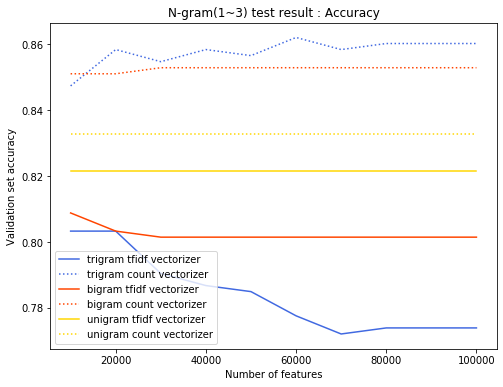

In [121]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy,tt_time))
    return result

from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))


nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [123]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier


names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid","Random Forest"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid(),
    RandomForestClassifier(),
    KNeighborsClassifier
    ]
zipped_clf = zip(names,classifiers)

cvec = CountVectorizer()
def classifier_comparator(vectorizer=cvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

trigram_result = classifier_comparator(n_features=60000,ngram_range=(1,3))




Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
null accuracy: 72.79%
accuracy score: 86.21%
model is 13.42% more accurate than null accuracy
train and test time: 0.64s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
null accuracy: 72.79%
accuracy score: 85.48%
model is 12.68% more accurate than null accuracy
train and test time: 0.60s
----------------------------------------------

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


null accuracy: 72.79%
accuracy score: 82.72%
model is 9.93% more accurate than null accuracy
train and test time: 0.82s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
null accuracy: 72.79%
accuracy score: 81.62%
model is 8.82% more accurate than null accuracy
train and test time: 0.36s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
null accuracy: 72.79%
accuracy score: 72.79%
model has the same accuracy with the null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
       

In [124]:
trigram_result = pd.DataFrame(trigram_result)

In [125]:
trigram_result.columns = ['Algorithm','Training Set Accuracy','time']

In [126]:
# "trigram_result = trigram_result.sort_values('Training Set Accuracy', ascending = False)

In [92]:
trigram_result

NameError: name 'trigram_result' is not defined

NameError: name 'trigram_result' is not defined

In [89]:
sorted(trigram_result,"Training Set Accuracy")

NameError: name 'trigram_result' is not defined

In [128]:
from sklearn.ensemble import VotingClassifier

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = RidgeClassifier()
clf4 = PassiveAggressiveClassifier()
clf5 = Perceptron()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC','Ridge Classifier','Passive', 'Perceptron', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', CountVectorizer(max_features=60000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print("Validation result for {}".format(label))
    print(clf)
    clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
null accuracy: 72.79%
accuracy score: 86.21%
model is 13.42% more accurate than null accuracy
train and test time: 0.68s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


null accuracy: 72.79%
accuracy score: 85.48%
model is 12.68% more accurate than null accuracy
train and test time: 0.63s
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
null accuracy: 72.79%
accuracy score: 85.48%
model is 12.68% more accurate than null accuracy
train and test time: 0.53s
--------------------------------------------------------------------------------
Validation result for Passive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight=None,
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation

//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
